<a href="https://colab.research.google.com/github/ryann-arruda/deep_learning_algorithms/blob/main/perceptron/pytorch_implementation/problems/fashion_mnist/fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import torch
from torch.utils.data import random_split, DataLoader
from torch.functional import F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import transforms
from torchvision.utils import make_grid
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

## **Loading the Dataset**

In [13]:
train_dataset = FashionMNIST(root='./data',
                             train=True,
                             transform=transforms.ToTensor(),
                             download=True)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.49MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.3MB/s]


In [15]:
test_dataset = FashionMNIST(root='./data',
                            train=False,
                            transform=transforms.ToTensor())

## **Separating the Dataset**

In [18]:
torch.manual_seed(27)

In [24]:
train_length = int(len(train_dataset) * 0.9)

In [25]:
val_length = int(len(train_dataset) * 0.1)

In [27]:
train_dataset, val_dataset = random_split(train_dataset, lengths=[train_length, val_length])

## **Creating the Dataloader Object**

In [29]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=64,
                              shuffle=True,
                              num_workers=2)

In [31]:
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=64,
                             shuffle=False,
                             num_workers=2)

In [32]:
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=64,
                            shuffle=False,
                            num_workers=2)

## **Analysis of Class Distribution**

### **Train**

In [34]:
train_counter = Counter()

In [35]:
for _, labels in train_dataloader:
  train_counter.update(labels.tolist())

In [36]:
print("Train label distribution: ", sorted(train_counter.items()))

Train label distribution:  [(0, 5402), (1, 5411), (2, 5407), (3, 5373), (4, 5382), (5, 5373), (6, 5409), (7, 5406), (8, 5390), (9, 5447)]


### **Test**

In [37]:
test_counter = Counter()

In [38]:
for _, labels in test_dataloader:
  test_counter.update(labels.tolist())

In [39]:
print("Test label distribution: ", sorted(test_counter.items()))

Test label distribution:  [(0, 1000), (1, 1000), (2, 1000), (3, 1000), (4, 1000), (5, 1000), (6, 1000), (7, 1000), (8, 1000), (9, 1000)]


### **Val**

In [40]:
val_counter = Counter()

In [41]:
for _, labels in val_dataloader:
  val_counter.update(labels.tolist())

In [42]:
print("Val labels distribution: ", sorted(val_counter.items()))

Val labels distribution:  [(0, 598), (1, 589), (2, 593), (3, 627), (4, 618), (5, 627), (6, 591), (7, 594), (8, 610), (9, 553)]


## **Viewing some Data**

In [43]:
for images, _ in train_dataloader:
  pass

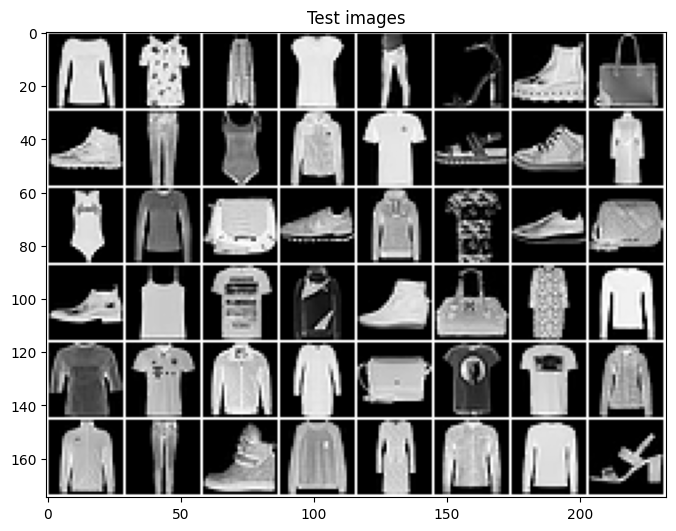

In [52]:
plt.figure(figsize=(8,8))
plt.title("Test images")
plt.imshow(np.transpose(make_grid(images[:64],
                     padding=1,
                     pad_value=1.0,
                     normalize=True), (1,2,0)))

## **MLP**

In [56]:
images[0].flatten().shape

torch.Size([784])

In [65]:
class MLP(torch.nn.Module):
  def __init__(self, input, output):
    super().__init__()

    self.layers = torch.nn.Sequential(
        torch.nn.Linear(input, 256),
        torch.nn.ReLU(),

        torch.nn.Linear(256, 128),
        torch.nn.ReLU(),

        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),

        torch.nn.Linear(64, output),
    )

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    return self.layers(x)

In [60]:
height, width = images[0].shape[1:]

In [62]:
input_size = height * width

In [100]:
model = MLP(input=input_size, output=10)

In [101]:
model.to('cuda')

MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [102]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

## **Training**

In [103]:
def accuracy(model, dataloader):
  model = model.eval()

  accuracy = 0.0
  total = 0

  for x,y in dataloader:
    x = x.to('cuda')
    y = y.to('cuda')

    with torch.inference_mode():
      z = model(x)

    labels = torch.argmax(z, dim=1)
    labels = labels.view(y.shape).to(y.dtype)

    results = labels == y
    accuracy += torch.sum(results).item()
    total += len(results)

  return (accuracy/total)

In [104]:
epochs = 10

In [105]:
for epoch in range(epochs):
  model = model.train()

  for index, (x, y) in enumerate(train_dataloader):
    x = x.to('cuda')
    y = y.to('cuda')

    z = model(x)
    loss = F.cross_entropy(z, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if index % 100 == 0:
      print(f'Epoch: {epoch+1:03d}/{epochs:03d} - Batch: {index+1:03d}/{len(train_dataloader):03d} - Loss: {loss:.2f}')

  print(f'Train Accuracy: {accuracy(model, train_dataloader)*100:0.2f}% - Val Accuracy: {accuracy(model, val_dataloader)*100:.2f}%')

Epoch: 001/010 - Batch: 001/844 - Loss: 2.28
Epoch: 001/010 - Batch: 101/844 - Loss: 1.20
Epoch: 001/010 - Batch: 201/844 - Loss: 0.95
Epoch: 001/010 - Batch: 301/844 - Loss: 0.74
Epoch: 001/010 - Batch: 401/844 - Loss: 0.57
Epoch: 001/010 - Batch: 501/844 - Loss: 0.62
Epoch: 001/010 - Batch: 601/844 - Loss: 0.81
Epoch: 001/010 - Batch: 701/844 - Loss: 0.56
Epoch: 001/010 - Batch: 801/844 - Loss: 0.46
Train Accuracy: 78.75% - Val Accuracy: 78.57%
Epoch: 002/010 - Batch: 001/844 - Loss: 0.70
Epoch: 002/010 - Batch: 101/844 - Loss: 0.46
Epoch: 002/010 - Batch: 201/844 - Loss: 0.53
Epoch: 002/010 - Batch: 301/844 - Loss: 0.46
Epoch: 002/010 - Batch: 401/844 - Loss: 0.47
Epoch: 002/010 - Batch: 501/844 - Loss: 0.41
Epoch: 002/010 - Batch: 601/844 - Loss: 0.40
Epoch: 002/010 - Batch: 701/844 - Loss: 0.50
Epoch: 002/010 - Batch: 801/844 - Loss: 0.54
Train Accuracy: 80.25% - Val Accuracy: 80.20%
Epoch: 003/010 - Batch: 001/844 - Loss: 0.51
Epoch: 003/010 - Batch: 101/844 - Loss: 0.41
Epoch: 0

## **Evaluating the Results**

In [106]:
print(f'Test Accuracy: {accuracy(model, test_dataloader)*100:0.2f}%')

Test Accuracy: 84.04%
